Scratch Jupyter Noteboook

In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import nonlinear_approximator as na
from importlib import reload
import torch
import torchvision
import PIL
%matplotlib inline
from dask.distributed import Client, LocalCluster
import dask
import dask.array as da

Dask Client for Distributed Computation 

# Load and Plot MNIST Dataset 

In [2]:
def one_hot_ten(int_label: torch.Tensor) -> NDArray[np.floating]:
    oh = np.zeros((10,))
    oh[int_label] = 1
    return oh

def to_numpy_arr(img: PIL.Image) -> NDArray[np.floating]:
    # rescale 255 to +/- 1 
    arr = np.asarray(img).flatten()
    arr = arr / 255 # 0 --> 1
    arr = arr - .5  # -.5 --> .5
    arr = 2 * arr   # -1 --> 1
    return arr
    
    


In [3]:
train_data = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=to_numpy_arr, target_transform=one_hot_ten)
test_data = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=to_numpy_arr, target_transform=one_hot_ten)

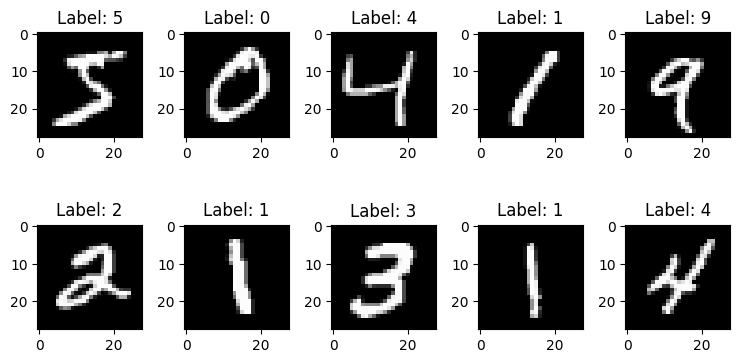

In [4]:
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5*num_cols,2*num_rows))
for i in range(num_rows*num_cols):
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(train_data[i][0].reshape((28, 28)), cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(train_data[i][1])))
plt.tight_layout()
plt.show()

# Parameters

In [5]:
reload(na)
reload(na.model)
reload(na.activations)
reload(na.params)
reload(na.training)

config = na.params.RegressionParams(
    width=1000,
    depth=50,
    input_dimension=len(train_data[0][0]),
    transform_type=na.activations.TransformType.TENT,
    transform_params=na.params.TentParams(mu=1.99),
    output_dimension=len(train_data[0][1]),
    batch_size=1000,
)


# Instantiate Model

In [6]:
model = na.model.NonlinearRegressorModel(config)
imgs_train, labels_train = zip(*train_data)
imgs_train = da.array(imgs_train).persist()
labels_train = da.array(labels_train).persist()

imgs_test, labels_test = zip(*test_data)
imgs_test = da.array(imgs_test).persist()
labels_test = da.array(labels_test).persist()

print(f"Loaded training data images with shape {imgs_train.shape}, and labels with shape {labels_train.shape}")
print(f"Loaded test data images with shape {imgs_test.shape}, and labels with shape {labels_test.shape}")


/home/fritz/untitled/.venv/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 358.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Loaded training data images with shape (60000, 784), and labels with shape (60000, 10)
Loaded test data images with shape (10000, 784), and labels with shape (10000, 10)


/home/fritz/untitled/.venv/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 59.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2025-07-01 12:15:04,585 - distributed.client - ERROR - 
Traceback (most recent call last):
  File "/home/fritz/untitled/.venv/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fritz/untitled/.venv/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/fritz/untitled/.venv/lib/python3.11/site-packages/distributed/client.py", line 1751, in _handle_report
    msgs = await self.scheduler_comm.comm.read()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fritz/untitled/.venv/lib/python3.11/site-packages/distributed/comm/tcp.py", line 237, in read
    convert_stream_closed_err

# Train MNIST Classifier

In [7]:
model.fit(imgs_train[:1000, :], labels_train[:1000, :])

FutureCancelledError: _regress_neuron-799fc66a439177c4e26d10b0703587a9 cancelled for reason: scheduler-connection-lost.
Client lost the connection to the scheduler. Please check your connection and re-run your work.

In [ ]:
probs_train = model.predict(imgs_train[:1000, :])
preds_train = probs_train.argmax(axis=0)
acc_train = (sum(
    preds_train == (labels_train.argmax(axis=1)[:1000])
    ) / len(preds_train)).compute()

100%|██████████| 100/100 [00:00<00:00, 136.23it/s]


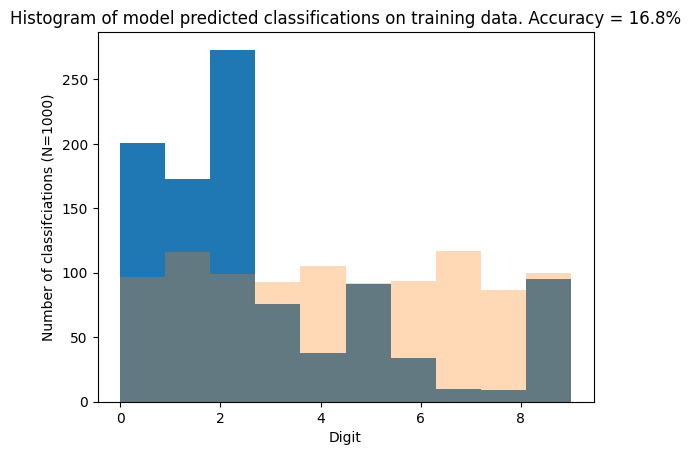

In [ ]:
plt.hist(preds_train, bins=10)
plt.hist(labels_train.argmax(axis=1)[:1000].compute(), bins=10, alpha=0.3)
plt.title(f"Histogram of model predicted classifications on training data. Accuracy = {100 *acc_train}%")
plt.xlabel("Digit")
plt.ylabel(f"Number of classifciations (N={len(preds_train)})")
plt.show()

In [ ]:
probs_test = model.predict(imgs_train[:,:1000]) 
preds_test = probs_test.T.argmax(axis=0)
acc_test = sum(preds_test==labels_test.argmax(axis=0)[:1000]) / len(preds_test)

plt.hist(preds_test, bins=10)
plt.hist(labels_test.argmax(axis=0)[:1000], bins=10, alpha=0.3)
plt.title(f"Histogram of model predicted classifications on test data. Accuracy = {100 *acc_test}%")
plt.xlabel("Digit")
plt.ylabel(f"Number of classifciations (N={len(preds_test)})")
plt.show()